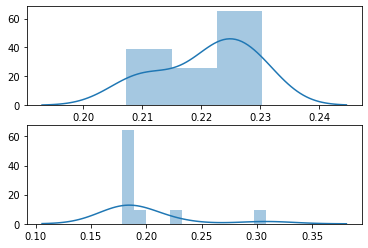

In [10]:
import random
import kfp
import os
import string
import time
from google.cloud import storage
from kfp.components import create_component_from_func
from datetime import datetime, timezone, timedelta

# plot libs
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# change number of nodes and number of uploads here
host = 'http://127.0.0.1:3000'
num_nodes = 10
num_uploads = 10

file_name = 'test_' + str(num_nodes) + '_nodes.yaml'
pipeline_name_prefix = 'pipeline_' + os.path.splitext(file_name)[0] + '_'
bucket_name = ''


@create_component_from_func
def add_op(a: float, b: float) -> float:
    return a + b


def generated_pipeline():
    """Generates a pipeline with randomly connected component graph."""
    tasks = [add_op(3, 5)]
    for _ in range(num_nodes):
        a = random.choice(tasks).output
        b = random.choice(tasks).output
        task = add_op(a, b)
        tasks.append(task)


if __name__ == '__main__':
    # Prepare pipeline file
    kfp.compiler.Compiler().compile(generated_pipeline, file_name)
    client = kfp.Client(host)
    pipeline_file = os.path.join(file_name)

    # Measure upload latency
    upload_latencies = []
    for i in range(num_uploads):
      start = time.perf_counter()
      pipeline = client.pipeline_uploads.upload_pipeline(pipeline_file, name=pipeline_name_prefix + ''.join(random.choices(string.ascii_lowercase + string.digits, k=10)))
      dur = time.perf_counter() - start
      upload_latencies.append(dur)
        
    # Measure upload latency
    upload_latencies = []
    uploaded_pipeline_ids = []
    for i in range(num_uploads):
      start = time.perf_counter()
      pipeline = client.pipeline_uploads.upload_pipeline(pipeline_file, name=pipeline_name_prefix + ''.join(random.choices(string.ascii_lowercase + string.digits, k=10)))  
      dur = time.perf_counter() - start
      uploaded_pipeline_ids.append(pipeline.id)
      upload_latencies.append(dur)    
    
    # Measure get latency
    get_latencies = []
    for i in uploaded_pipeline_ids:
      start = time.perf_counter()
      pipeline = client.pipelines.get_pipeline(i)  
      dur = time.perf_counter() - start
      get_latencies.append(dur)      

    # Plot
    fig, axs = plt.subplots(nrows=2)
    sns.distplot(a=upload_latencies, ax=axs[0])
    sns.distplot(a=get_latencies, ax=axs[1])
    
    # TODO(jingzhang36): maybe dump the durations data to db or gcs, and let searborn read from there